# Exploration des données

Nous allons maintenant passer en revue les caractéristiques une par une pour en dégager des tendances

 1. Je dois m'améliorer avec les pièces noires.                 
 2. Je dois mieux gérer mon temps.               
 3. Je dois m'améliorer à l'ouverture.              
 4. Je dois m'améliorer en fin de partie.                 
 5. Je dois travailler mon mental car j'ai tendance à enchaîner les défaites.

**Importer les librairies**

In [1]:
import pandas as pd #données tabulaires
import numpy as np #algèbre linéaire
import seaborn as sns #data viualisation
import matplotlib.pyplot as plt #data visualisation
plt.style.use('fivethirtyeight')

**Charger le jeu de données**

In [2]:
chess_data = pd.read_csv('CleanLichessData.csv')
chess_data.iloc[0]

DateTime                                            2017-06-04 20:33:05
GameId                                                                0
TimeControl                                                       600+0
MyColor                                                           Black
OpponentName                                                    arilico
MyElo                                                              1500
OpponentElo                                                        1404
EloDifference                                                        96
ECO                                                                 C20
Moves                 1. e4 e5 2. Qf3 Nf6 3. Nc3 b6 4. Bc4 Bb7 5. Nd...
MyRatingDiff                                                       -230
OpponentRatingDiff                                                    9
Finish                                                          TimeOut
MyResult                                                        

**Séparer le jeu de données en 2 en fonction du modes de jeu**

In [3]:
blitz_games = chess_data[chess_data['TimeControl']=='180+2'].copy().drop('TimeControl',axis=1)

bullet_games=chess_data[chess_data['TimeControl']=='60+0'].copy().drop('TimeControl',axis=1)

On va se concentrer sur les blitz dans un premier temps

**Comment évolue mon clasement Elo au cours du temps?**

In [4]:
blitz_games['GameId'] = np.arange(blitz_games.shape[0])

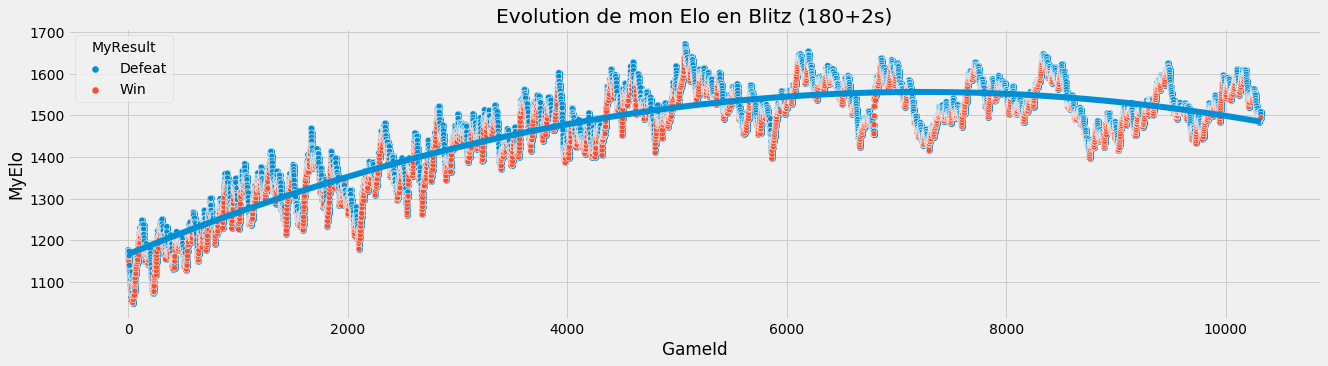

In [5]:
plt.figure(figsize=(20,5))
sns.regplot(data=blitz_games,x='GameId', y='MyElo',order=2)
sns.scatterplot(data=blitz_games,x='GameId',y='MyElo',hue='MyResult')
plt.title('Evolution de mon Elo en Blitz (180+2s)')
plt.show()

Cet affichage donne envie de s'intéresser aux victoires et défaites consécutives.           
Il montre également 2 phases distinctes dans l'évolution de mon classement:                  
- une progression rapide sur la première moitié des parties jouées                               
- une stagnation depuis             
C'est cette stagnation qui nous intéresse. On va donc réduire la taile du jeu de données

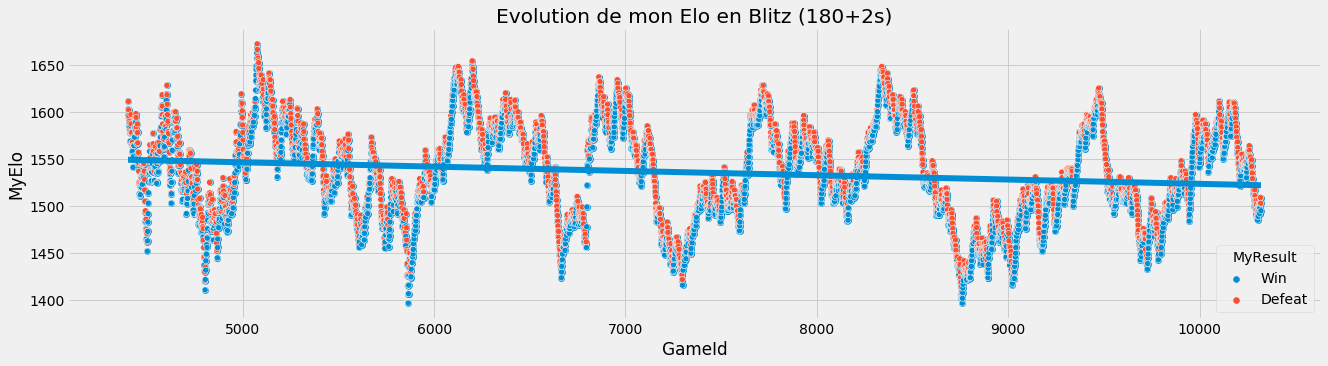

In [6]:
blitz_games = blitz_games[blitz_games['GameId']>=4400]

plt.figure(figsize=(20,5))
sns.regplot(data=blitz_games,x='GameId', y='MyElo',order=1)
sns.scatterplot(data=blitz_games,x='GameId',y='MyElo',hue='MyResult')
plt.title('Evolution de mon Elo en Blitz (180+2s)')
plt.show()

In [7]:
begin_stagnation = blitz_games.DateTime.min()

print('Début de la période de stagnation:', begin_stagnation)

Début de la période de stagnation: 2019-05-25 17:40:19


**Quel est mon taux de victoires par couleur?**

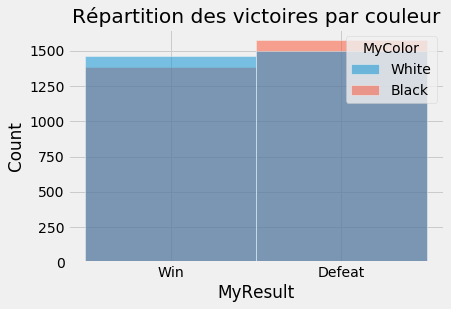

In [8]:
sns.histplot(data=blitz_games,x='MyResult',hue='MyColor')
plt.title('Répartition des victoires par couleur')
plt.show()

Tout est équilibré. J'ai joué la moitié des parties en blanc et l'autre en noirs. J'ai gagné la moitié des parties, la moitié des parties où j'ai joué avec les noirs, et la moitié des parties où j'ai joué avec les blancs.              
Il est donc clair que la couleur ne joue pas un rôle important dans le résultat final

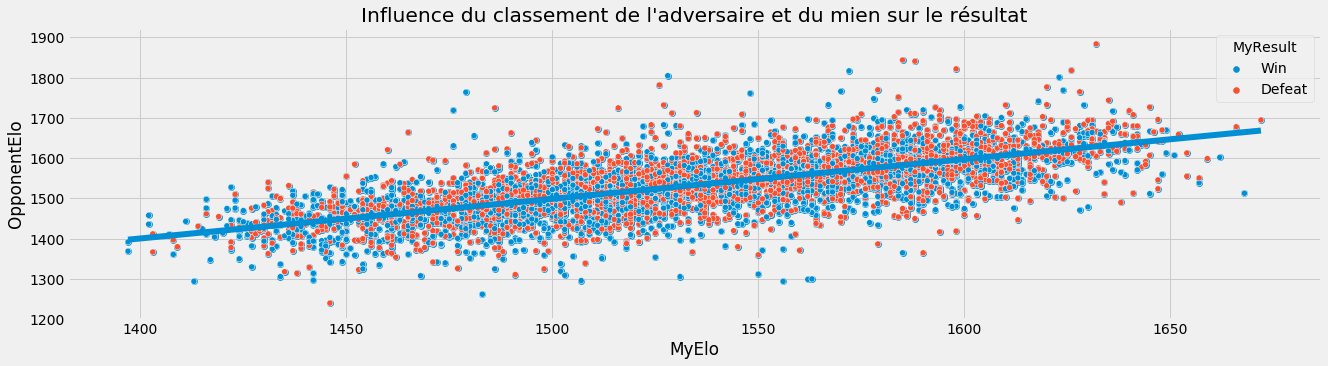

In [9]:
plt.figure(figsize=(20,5))
sns.regplot(data=blitz_games,x='MyElo', y='OpponentElo')
sns.scatterplot(data=blitz_games, x='MyElo',y='OpponentElo',hue='MyResult')
plt.title('Influence du classement de l\'adversaire et du mien sur le résultat')
plt.show()

Le système de matchmaking de Lichess me fait jouer contre des adversaires dont le clasement Elo est proche du mien. C'est un frein à la progression car on apprend davantage des joueurs meilleurs que soi.         


In [10]:
blitz_games.columns

Index(['DateTime', 'GameId', 'MyColor', 'OpponentName', 'MyElo', 'OpponentElo',
       'EloDifference', 'ECO', 'Moves', 'MyRatingDiff', 'OpponentRatingDiff',
       'Finish', 'MyResult', 'Win'],
      dtype='object')

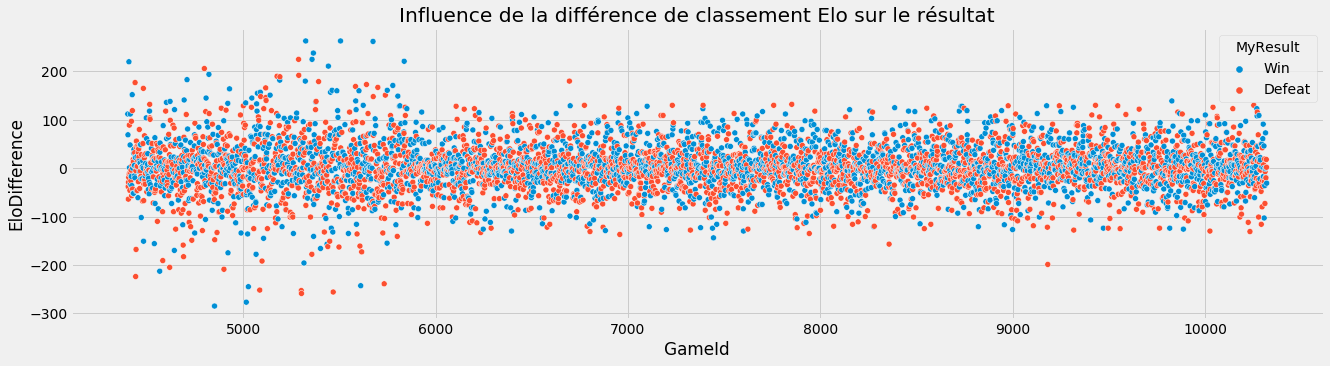

In [11]:
plt.figure(figsize=(20,5))
sns.scatterplot(data=blitz_games, x='GameId',y='EloDifference',hue='MyResult')
plt.title('Influence de la différence de classement Elo sur le résultat')
plt.show()

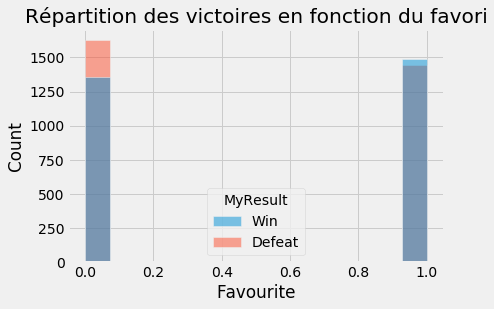

In [12]:
blitz_games['Favourite'] = 1*(blitz_games['EloDifference']>0)

sns.histplot(data=blitz_games,x='Favourite',hue='MyResult')
plt.title('Répartition des victoires en fonction du favori')
plt.show()

In [13]:
blitz_games.columns

Index(['DateTime', 'GameId', 'MyColor', 'OpponentName', 'MyElo', 'OpponentElo',
       'EloDifference', 'ECO', 'Moves', 'MyRatingDiff', 'OpponentRatingDiff',
       'Finish', 'MyResult', 'Win', 'Favourite'],
      dtype='object')

ECO

Tableau de correspondance des variantes: https://lichess.org/forum/general-chess-discussion/eco-code-csv-sheet

In [14]:
correspondance = pd.read_csv('ChessOpeningReference.csv').set_index('ECO Code')
correspondance.head()

,Name,Opening Moves
ECO Code,,
A00,Uncommon Opening,"1 g4, a3, h3, etc."
A01,Nimzovich-Larsen Attack,1 b3
A02,Bird's Opening,1 f4
A03,Bird's Opening,1 f4 d5
A04,Reti Opening,1 Nf3


In [15]:
def name(eco):
    return correspondance.set_index('ECO Code')[eco]

In [16]:
correspondance.loc['B30']

Name                      Sicilian
Opening Moves    1 e4 c5 2 Nf3 Nc6
Name: B30, dtype: object

In [17]:
def variant_table(df=blitz_games):
    table = pd.DataFrame(df['ECO'].unique(),columns=['ECO'])
    table['Played'] = table['ECO'].apply(lambda x: (df['ECO']==x).sum())
    table['Won']= table['ECO'].apply(lambda x: (df[df['ECO']==x]['Win']).sum())
    table['Lost'] = table['ECO'].apply(lambda x: (~df[df['ECO']==x]['Win']).sum())
    table['Win%'] = np.round(100*table['Won']/table['Played']).astype(int)
    
    table = table.sort_values('Win%')
    table=table[table['Played']>100]
    
    table['Nom'] = table['ECO'].apply(lambda eco:correspondance.loc[eco,'Name'])
    table['Premiers coups'] =table['ECO'].apply(lambda eco:correspondance.loc[eco,'Opening Moves'])
    return table

white_blitz = blitz_games[blitz_games['MyColor']=='White'].copy()
black_blitz = blitz_games[blitz_games['MyColor']=='Black'].copy()

ouvertures = variant_table()
white_ouvertures = variant_table(white_blitz)
black_ouvertures = variant_table(black_blitz)


In [18]:
ouvertures.head(5)

,ECO,Played,Won,Lost,Win%,Nom,Premiers coups
54,A10,155,59,96,38,English,1 c4
16,B33,106,41,65,39,Sicilian,1 e4 c5 2 Nf3 Nc6 3 d4 cxd4 4 Nxd4
70,A80,359,147,212,41,Dutch,1 d4 f5
46,A85,227,95,132,42,"Dutch, with c4 & Nc3",1 d4 f5 2 c4 Nf6 3 Nc3
30,B00,106,45,61,42,Uncommon King's Pawn Opening,1 e4


In [19]:
white_ouvertures.head(5)

,ECO,Played,Won,Lost,Win%,Nom,Premiers coups
36,A10,119,46,73,39,English,1 c4
6,D10,117,61,56,52,Queen's Gambit Declined Slav,1 d4 d5 2 c4 c6
22,A22,136,71,65,52,English,1 c4 e5 2 Nc3 Nf6
17,A21,113,60,53,53,English,1 c4 e5 2 Nc3
14,D06,118,65,53,55,Queen's Gambit Declined,1 d4 d5 2 c4


In [20]:
black_ouvertures.head(5)

,ECO,Played,Won,Lost,Win%,Nom,Premiers coups
5,B33,104,41,63,39,Sicilian,1 e4 c5 2 Nf3 Nc6 3 d4 cxd4 4 Nxd4
36,A80,356,145,211,41,Dutch,1 d4 f5
18,A85,209,89,120,43,"Dutch, with c4 & Nc3",1 d4 f5 2 c4 Nf6 3 Nc3
4,B32,314,141,173,45,Sicilian,1 e4 c5 2 Nf3 Nc6 3 d4 cxd4 4 Nxd4 e5
0,B20,266,139,127,52,Sicilian,1 e4 c5


MyRatingDiff

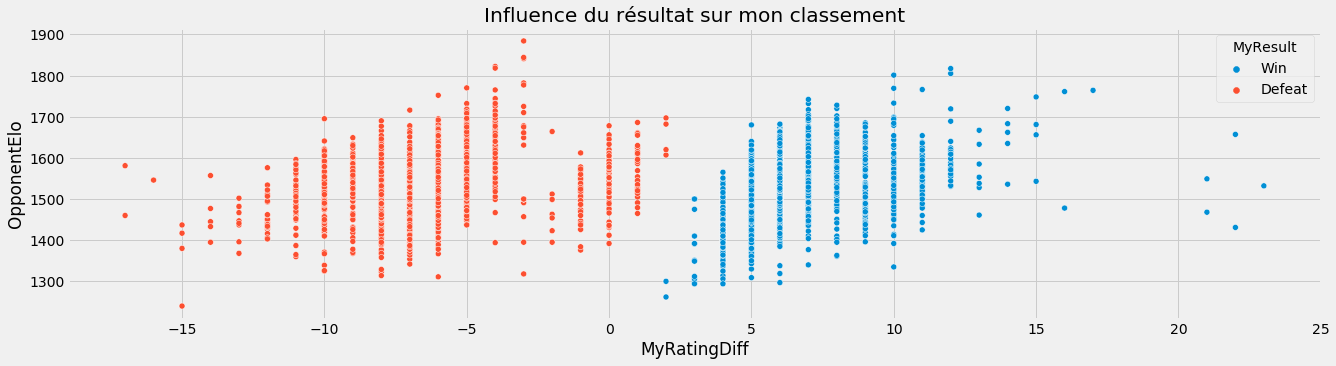

In [21]:
plt.figure(figsize=(20,5))
sns.scatterplot(data=blitz_games, y='OpponentElo',x='MyRatingDiff', hue='MyResult')
plt.title('Influence du résultat sur mon classement')
plt.show()

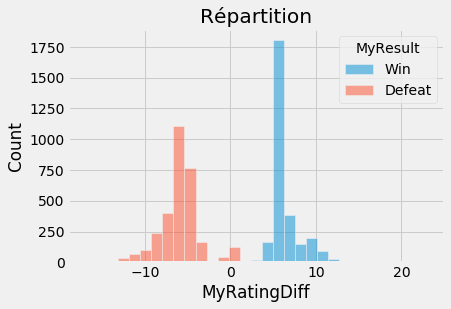

In [22]:
sns.histplot(data=blitz_games,x='MyRatingDiff',hue='MyResult')
plt.title('Répartition')
plt.show()

Finish

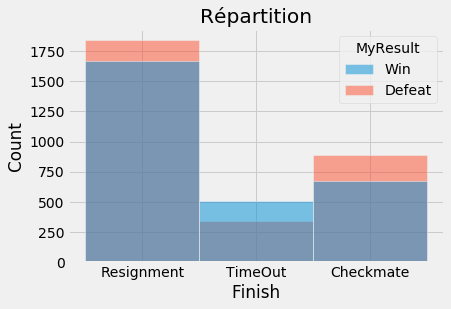

In [23]:
sns.histplot(data=blitz_games,x='Finish',hue='MyResult')
plt.title('Répartition')
plt.show()

- étendre l'analyse aux bullet                
- s'intéresser aux victoires et défaites consécutives                            
- supprimer les premières parties du jeu de données car elles faussent l'analyse                 
- aucune influence de la couleur (toute seule en tout cas)                        
- jouer avec des joueurs d'un meilleur niveau serait bénéfique               
- apprendre à jouer l'ouverture sicilienne avec les noirs           
- apprendre à jouer l'anglaise avec les blancs              
- de façon surprenante le temps n'est pas un facteur important pour ce mode de jeu

In [34]:
streaks = blitz_games[['MyResult']].copy().rename({'MyResult':'result'}, axis=1)

In [35]:
streaks.head()

,result
6401,Win
6402,Win
6403,Defeat
6404,Defeat
6405,Defeat


In [48]:
streaks['start_of_streak'] = streaks.result.ne(streaks.result.shift())
streaks['streak_id'] = streaks['start_of_streak'].cumsum()
streaks['streak_counter'] = streaks.groupby('streak_id').cumcount()+1

streaks['end_of_streak']= streaks['start_of_streak'].shift(-1, fill_value=True)
streaks = streaks[streaks['end_of_streak']][['result','streak_counter']].reset_index()

In [50]:
streaks['streak_counter'].describe()

count    3019.000000
mean        1.961577
std         1.343509
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        11.000000
Name: streak_counter, dtype: float64

In [52]:
sns.lineplot(data = streaks[streaks['result']=='Win']['streak_counter'].describe().drop(['count','mean','std'],
                                                                                      x=streaks[streaks['result']=='Win'].index,
                                                                                      y='')
streaks[streaks['result']=='Win']['streak_counter'].describe().drop(['count','mean','std'])


count    1510.000000
mean        1.885430
std         1.279698
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        11.000000
Name: streak_counter, dtype: float64

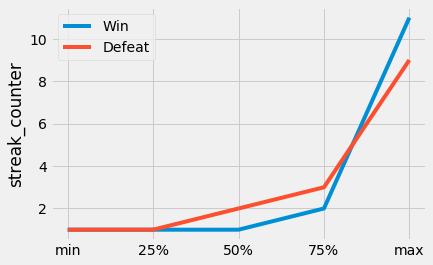

In [64]:
winning_streaks = streaks.loc[streaks['result']=='Win','streak_counter'].describe()[['min','25%','50%','75%','max']]
sns.lineplot(winning_streaks, label='Win')
losing_streaks = streaks.loc[streaks['result']!='Win','streak_counter'].describe()[['min','25%','50%','75%','max']]
sns.lineplot(losing_streaks, label='Defeat')
# streaks_describe = streaks['streak_counter'].describe()[['min','25%','50%','75%','max']]
# sns.lineplot(streaks_describe)

In [65]:
losing_streaks

min    1.0
25%    1.0
50%    2.0
75%    3.0
max    9.0
Name: streak_counter, dtype: float64

In [66]:
winning_streaks

min     1.0
25%     1.0
50%     1.0
75%     2.0
max    11.0
Name: streak_counter, dtype: float64

# The End

**Fait par Youness Khanjar**